In [1]:
import os
os.environ['KAGGLE_USERNAME']='jangdasom'
os.environ['KAGGLE_KEY']="05d518bda0bb012d02c772eaa9deb02b"
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.4MB 2.8MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 1.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=52588439427e1a2ceb6121620b201a3b2b928ccb301f34264b78f8072a1ff384
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle


In [2]:
!kaggle competitions download -c dog-breed-identification

 97% 672M/691M [00:05<00:00, 118MB/s] 
100% 691M/691M [00:05<00:00, 136MB/s]


In [3]:
!unzip dog-breed-identification.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/841463629c4833816e216cbb041c2778.jpg  
  inflating: train/8429dcca4ae91c4e0

In [4]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import PIL.Image as Image

In [7]:
label_text=pd.read_csv('labels.csv')
label_text.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [7]:
label_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
id       10222 non-null object
breed    10222 non-null object
dtypes: object(2)
memory usage: 159.8+ KB


In [8]:
label_text['breed'].nunique() #class 갯수 : 120개

120

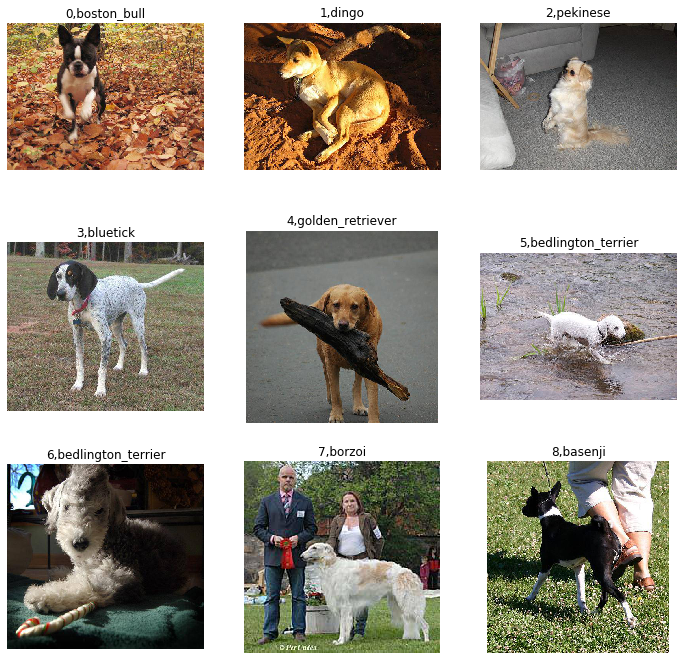

In [9]:
plt.figure(figsize=(12,12))

for c in range(9):
  #image_id=label_text.loc[c,'id']
  image_id=label_text['id'][c]
  plt.subplot(3,3,c+1)
  plt.imshow(plt.imread('/content/train/'+image_id+'.jpg'))
  plt.title(str(c)+','+label_text.loc[c,'breed'])
  plt.axis('off')

plt.show()

In [10]:
mobilev2=tf.keras.applications.MobileNetV2()

14540800/14536120 [==============================] - 0s 0us/step


In [0]:
for layer in mobilev2.layers[:-1]:
  layer.trainable=True # 각 레이어의 훈련 여부를 true로 바꿈, 마지막 레이어인 Dense(activation=softmax)는 사용하지 않음
for layer in mobilev2.layers[:-1]:
  if 'kernel' in layer.__dict__: # 각 레이어에 kernel(w) 이 있는지 확인하기 
    kernel_shape=np.array(layer.get_weights()).shape # 해당 레이어의 가중치 shape
    layer.set_weights(tf.random.normal(kernel_shape,0,1)) # 가중치 초기화
# 'https://keras.io/ko/layers/about-keras-layers/'

In [12]:
len(label_text)

10222

In [13]:
train_X=[]

for i in range(len(label_text)):
  img=cv2.imread('/content/train/'+label_text['id'][i]+'.jpg')
  img=cv2.resize(img,dsize=(224,224))
  img=img/255.0
  train_X.append(img)

train_X=np.array(train_X)
print(train_X.shape)
print(train_X.size*train_X.itemsize,'bytes')

(10222, 224, 224, 3)
12309577728 bytes


In [0]:
unique_Y=label_text['breed'].unique().tolist() # unique labels np.array->list
train_Y=[unique_Y.index(breed) for breed in label_text['breed']] # string type 라벨을 숫자로 바꿈
train_Y=np.array(train_Y) # list->np.array

In [15]:
x=mobilev2.layers[-2].output
predictions=tf.keras.layers.Dense(120,activation='softmax')(x)

model=tf.keras.Model(inputs=mobilev2.input,outputs=predictions)
model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [16]:
history=model.fit(train_X,train_Y,epochs=10,validation_split=0.25,batch_size=32)

Train on 7666 samples, validate on 2556 samples
Epoch 1/10
7666/7666 [==============================] - 101s 13ms/sample - loss: 4.9136 - accuracy: 0.0067 - val_loss: 9.1373 - val_accuracy: 0.0074
Epoch 2/10
7666/7666 [==============================] - 88s 11ms/sample - loss: 4.8690 - accuracy: 0.0090 - val_loss: 8.6328 - val_accuracy: 0.0047
Epoch 3/10
7666/7666 [==============================] - 88s 12ms/sample - loss: 4.8441 - accuracy: 0.0133 - val_loss: 8.4984 - val_accuracy: 0.0067
Epoch 4/10
7666/7666 [==============================] - 88s 11ms/sample - loss: 4.8145 - accuracy: 0.0154 - val_loss: 7.9658 - val_accuracy: 0.0047
Epoch 5/10
7666/7666 [==============================] - 89s 12ms/sample - loss: 4.8050 - accuracy: 0.0162 - val_loss: 7.9424 - val_accuracy: 0.0074
Epoch 6/10
7666/7666 [==============================] - 88s 12ms/sample - loss: 4.7905 - accuracy: 0.0155 - val_loss: 7.6520 - val_accuracy: 0.0070
Epoch 7/10
7666/7666 [==============================] - 88s 12m

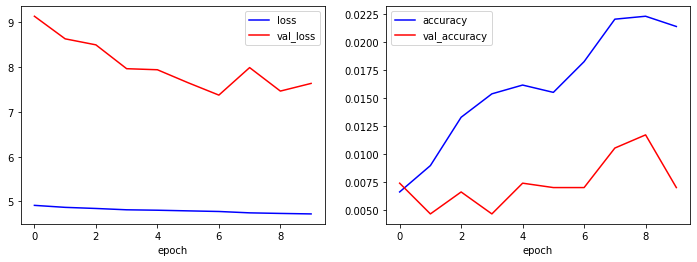

In [17]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'],'b-',label='loss')
plt.plot(history.history['val_loss'],'r-',label='val_loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],'b-',label='accuracy')
plt.plot(history.history['val_accuracy'],'r-',label='val_accuracy')
plt.xlabel('epoch')
plt.legend()

In [0]:
# 기존의 가중치를 그대로 두고 일부 레이어 가중치 만 학습

In [19]:
mobilenetv2=tf.keras.applications.MobileNetV2()
x=mobilenetv2.layers[-2].output
predictions=tf.keras.layers.Dense(120,activation='softmax')(x)
model=tf.keras.Model(inputs=mobilenetv2.input,outputs=predictions)

for layer in model.layers[:-20]:
  layer.trainable=False
for layer in model.layers[-20:]:
  layer.trainable=True;

model.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary

<bound method Network.summary of <tensorflow.python.keras.engine.training.Model object at 0x7ff686ab9f60>>

In [20]:
history=model.fit(train_X,train_Y,epochs=10,validation_split=0.25,batch_size=32)

Train on 7666 samples, validate on 2556 samples
Epoch 1/10
7666/7666 [==============================] - 33s 4ms/sample - loss: 3.3622 - accuracy: 0.2652 - val_loss: 2.1618 - val_accuracy: 0.4135
Epoch 2/10
7666/7666 [==============================] - 30s 4ms/sample - loss: 1.7553 - accuracy: 0.5693 - val_loss: 1.8476 - val_accuracy: 0.4887
Epoch 3/10
7666/7666 [==============================] - 30s 4ms/sample - loss: 1.2929 - accuracy: 0.6762 - val_loss: 1.7282 - val_accuracy: 0.5031
Epoch 4/10
7666/7666 [==============================] - 30s 4ms/sample - loss: 1.0317 - accuracy: 0.7527 - val_loss: 1.6403 - val_accuracy: 0.5286
Epoch 5/10
7666/7666 [==============================] - 30s 4ms/sample - loss: 0.8604 - accuracy: 0.8013 - val_loss: 1.6411 - val_accuracy: 0.5309
Epoch 6/10
7666/7666 [==============================] - 30s 4ms/sample - loss: 0.7326 - accuracy: 0.8355 - val_loss: 1.6342 - val_accuracy: 0.5403
Epoch 7/10
7666/7666 [==============================] - 30s 4ms/sample

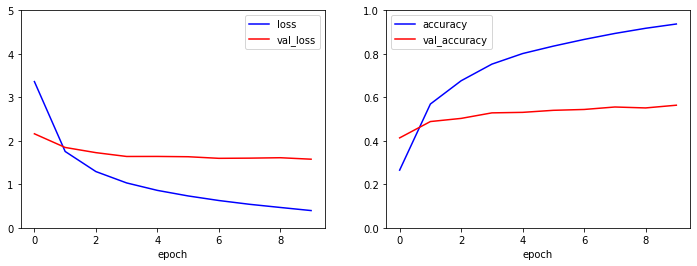

In [21]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'],'b-',label='loss')
plt.plot(history.history['val_loss'],'r-',label='val_loss')
plt.ylim(0,5)
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],'b-',label='accuracy')
plt.plot(history.history['val_accuracy'],'r-',label='val_accuracy')
plt.ylim(0,1)
plt.xlabel('epoch')
plt.legend()

feature extracter

In [0]:
import tensorflow_hub as hub

In [14]:
inception_url='https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'

feature_model=tf.keras.Sequential([
                                   hub.KerasLayer(inception_url,output_shape=(2048,),trainable=False)
                                   ])

feature_model.build([None,299,299,3])
feature_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  21802784  
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
import os
import shutil

#os.mkdir('/content/train_sub')

#train_sub 폴더에 라벨별로 이미지 분류하기
for i in range(len(label_text)):
  if os.path.exists('/content/train_sub/'+label_text['breed'][i])==False:
    os.mkdir('/content/train_sub/'+label_text['breed'][i])
  shutil.copy('/content/train/'+label_text['id'][i]+'.jpg','/content/train_sub/'+label_text['breed'][i])

In [10]:
image_size=299
batch_size=32

# data augmentation, img rescale
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,horizontal_flip=True, shear_range=0.2,zoom_range=0.2, width_shift_range=0.2,height_shift_range=0.2, validation_split=0.25)
# rescale image
valid_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,validation_split=0.25)

# flow_from_derectory :이미지를 불러올 때 폴더명에 맞춰서 자동으로 라벨링
train_generator=train_datagen.flow_from_directory(directory="/content/train_sub/",subset="training",batch_size=batch_size,seed=42,shuffle=True,class_mode="categorical",target_size=(image_size,image_size));
valid_generator=valid_datagen.flow_from_directory(directory="/content/train_sub/",subset="validation",batch_size=1,seed=42,shuffle=True,class_mode="categorical",target_size=(image_size,image_size));

Found 7718 images belonging to 120 classes.
Found 2504 images belonging to 120 classes.


In [15]:
batch_step=(7718*3)//batch_size

train_features=[]
train_Y=[]

for idx in range(batch_step):
  if idx%100==0:
    print(idx)
  x,y=train_generator.next()
  train_Y.extend(y)
  train_features.extend(feature_model.predict(x))


train_features=np.array(train_features)
train_Y=np.array(train_Y)

# https://ballentain.tistory.com/4 #

0
100
200
300
400
500
600
700


In [16]:
print(train_features.shape)
print(train_Y.shape)

(23084, 2048)
(23084, 120)


In [19]:
valid_features=[]
valid_Y=[]

for idx in range(valid_generator.n):
  if idx%100==0:
    print(idx)
  
  x,y=valid_generator.next()
  valid_Y.extend(y)
  valid_features.extend(feature_model.predict(x))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500


In [0]:
valid_features=np.array(valid_features)
valid_Y=np.array(valid_Y)

In [28]:
valid_Y.shape

(2504, 120)

In [21]:
model=tf.keras.Sequential([
                           tf.keras.layers.Dense(256,activation='relu',input_shape=(2048,)),
                           tf.keras.layers.Dropout(rate=0.5),
                           tf.keras.layers.Dense(120,activation='softmax')
])

model.compile(tf.optimizers.RMSprop(0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               30840     
Total params: 555,384
Trainable params: 555,384
Non-trainable params: 0
_________________________________________________________________


In [29]:
history=model.fit(train_features,train_Y,validation_data=(valid_features,valid_Y),epochs=10,batch_size=32);

Train on 23084 samples, validate on 2504 samples
Epoch 1/10
23084/23084 [==============================] - 3s 140us/sample - loss: 2.8996 - accuracy: 0.4417 - val_loss: 0.9455 - val_accuracy: 0.8658
Epoch 2/10
23084/23084 [==============================] - 3s 115us/sample - loss: 0.9533 - accuracy: 0.7788 - val_loss: 0.4259 - val_accuracy: 0.8934
Epoch 3/10
23084/23084 [==============================] - 3s 115us/sample - loss: 0.6304 - accuracy: 0.8260 - val_loss: 0.3465 - val_accuracy: 0.8986
Epoch 4/10
23084/23084 [==============================] - 3s 114us/sample - loss: 0.5078 - accuracy: 0.8511 - val_loss: 0.3262 - val_accuracy: 0.8986
Epoch 5/10
23084/23084 [==============================] - 3s 115us/sample - loss: 0.4517 - accuracy: 0.8654 - val_loss: 0.3058 - val_accuracy: 0.9042
Epoch 6/10
23084/23084 [==============================] - 3s 116us/sample - loss: 0.4075 - accuracy: 0.8748 - val_loss: 0.3030 - val_accuracy: 0.9034
Epoch 7/10
23084/23084 [===========================

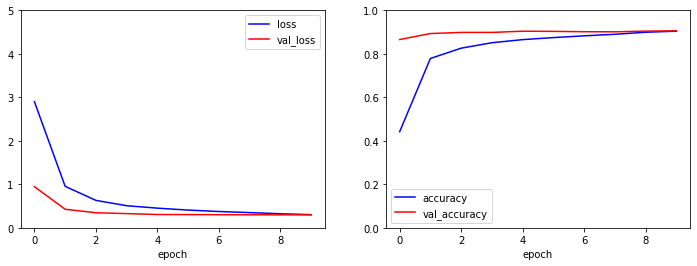

In [30]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'],'b-',label='loss')
plt.plot(history.history['val_loss'],'r-',label='val_loss')
plt.ylim(0,5)
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],'b-',label='accuracy')
plt.plot(history.history['val_accuracy'],'r-',label='val_accuracy')
plt.ylim(0,1)
plt.xlabel('epoch')
plt.legend()

In [0]:
unique_Y=label_text['breed'].unique().tolist()
unique_Y_sorted=sorted(unique_Y)

캐글에 제출

In [38]:
submission=pd.read_csv('sample_submission.csv')
print(submission.head())
print(submission.info())

                                 id  ...  yorkshire_terrier
0  000621fb3cbb32d8935728e48679680e  ...           0.008333
1  00102ee9d8eb90812350685311fe5890  ...           0.008333
2  0012a730dfa437f5f3613fb75efcd4ce  ...           0.008333
3  001510bc8570bbeee98c8d80c8a95ec1  ...           0.008333
4  001a5f3114548acdefa3d4da05474c2e  ...           0.008333

[5 rows x 121 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10357 entries, 0 to 10356
Columns: 121 entries, id to yorkshire_terrier
dtypes: float64(120), object(1)
memory usage: 9.6+ MB
None


In [0]:
import os
import shutil

os.mkdir('/content/test_sub/')
os.mkdir('/content/test_sub/unknown/')

for i in range(len(submission)):
  shutil.copy('/content/test/'+submission['id'][i]+'.jpg','/content/test_sub/unknown')


In [44]:
test_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
test_generator=test_datagen.flow_from_directory(directory='/content/test_sub/',batch_size=1,seed=42,shuffle=False,target_size=(299,299))

Found 10357 images belonging to 1 classes.


In [52]:
test_features=[]

for idx in range(test_generator.n):

  if idx%1000==0:
    print(idx)

  x,_=test_generator.next()
  test_features.extend(feature_model.predict(x))


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


AttributeError: ignored

In [53]:
test_features=np.array(test_features)
test_features.shape

(10357, 2048)

In [55]:
test_Y=model.predict(test_features,verbose=1)

10357/10357 [==============================] - 0s 47us/sample


In [56]:
for i in range(len(test_Y)):
  for j in range(len(test_Y[i])):
    breed_column=unique_Y_sorted[j]
    submission[breed_column][i]=test_Y[i,j]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
submission.to_csv('dogbreed_submission_inceptionV3_epoch_299.csv',index=False)